<a href="https://colab.research.google.com/github/samarth-t/Reddit-Upvote-Predictor/blob/master/predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install "dask[complete]" 
!python -m pip install dask-ml
!python -m pip install dask distributed --upgrade

In [2]:
from dask.distributed import Client
client = Client()
import dask.dataframe as dd
import dask.array as da
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import Incremental

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import joblib
from joblib import parallel_backend

from google.colab import drive
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Defining preprocessing functions using nltk
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return list(filter(lambda word: word.isalnum(), tokens))

In [5]:
file = "/content/drive/MyDrive/Eluvio/DSChallenge/Reddit_Upvote_Data.csv"

#only using 80% of data for test train split
data = dd.read_csv(file)
X_train, X_test, y_train, y_test = train_test_split(data['title'], data['up_votes'], test_size=0.2)

/usr/local/lib/python3.7/dist-packages/dask_ml/model_selection/_split.py:469: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  category=FutureWarning,


In [6]:
reg = Ridge()
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords.words('english'))

with parallel_backend('dask'):
  # Apply preprocessing and apply tf-idf transform
  tfidf.fit(X_train)
  X_train_tfidf = tfidf.transform(X_train)
  X_test_tfidf = tfidf.transform(X_test)
  reg.fit(X_train_tfidf, y_train)
  predictions = reg.predict(X_test_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


MAE:  208.63042120087073


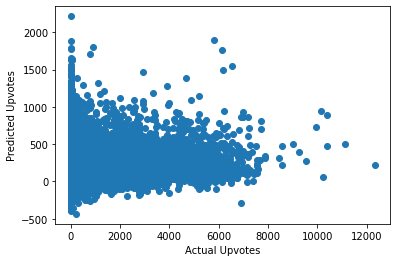

In [7]:
print('MAE: ', mean_absolute_error(predictions, y_test))

plt.scatter(y_test.to_dask_array(lengths=True), predictions)
plt.xlabel('Actual Upvotes')
plt.ylabel('Predicted Upvotes')
plt.show()